In [49]:
%matplotlib widget

from IPython.display import Markdown
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from joblib import Parallel, delayed

# Capacitance Calculator
In this script we solve for the capacitance of the Tesla coil top-load, usually a toroidal capacitor that couples to the environment. To this end we write down Gauss' law for the electric field $\vec{E}$ as
$$
\nabla \cdot \vec{E} = \frac{\rho}{\varepsilon_0\varepsilon_r},
$$
where $\rho$ is the charge density. Assuming absence of charges in free space, the euqation above reduces to
$$
\nabla \cdot \vec{E} = 0.
$$
We can then introduce the electric potential $U$ that allows to write the electric field as 
$$
\vec{E} = - \nabla U,
$$
and therefore equation 2 reduces to Laplace equation, namely
$$
\nabla^2 U = \frac{\partial^2U}{\partial x^2} + \frac{\partial^2U}{\partial y^2} + \frac{\partial^2U}{\partial z^2} = 0
$$

## Finite Differences
We now use the "finite differences" method to solve for the laplace equation in three dimensions. To this end, we consider the definition of partial derivatives as
\begin{align}
\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x + h, y, z) - U(x, y, z)}{h}, \\
\frac{\partial U}{\partial y} &= \lim_{h \to 0} \frac{U(x, y + h, z) - U(x, y, z)}{h}, \\
\frac{\partial U}{\partial z} &= \lim_{h \to 0} \frac{U(x, y, z + h) - U(x, y, z)}{h}.
\end{align}
Similarly, considering another function $f(x,y,z)$, we can write its partial derivatives as
\begin{align}
\frac{\partial f}{\partial x} &= \lim_{h \to 0} \frac{f(x, y, z) - f(x - h, y, z)}{h}, \\
\frac{\partial f}{\partial y} &= \lim_{h \to 0} \frac{f(x, y, z) - f(x, y - h, z)}{h}, \\
\frac{\partial f}{\partial z} &= \lim_{h \to 0} \frac{f(x, y, z) - f(x, y, z - h)}{h},
\end{align}
where we assume $f$ to be derivable on the entirety of $\mathbb{R}^3$. If we now let $f = \partial_{x,y,z}U$ we obtain the following expressions:
\begin{align}
\frac{\partial}{\partial x}\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x + h, y, z) - 2U(x, y, z) + U(x - h, y, z)}{h^2}, \\ 
\frac{\partial}{\partial y}\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x, y + h, z) - 2U(x, y, z) + U(x, y - h, z)}{h^2}, \\
\frac{\partial}{\partial z}\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x, y, z + h) - 2U(x, y, z) + U(x, y, z - h)}{h^2}.
\end{align}
If we now discretize the domain over which we evaluate $U$ such that $U_{i,j,k} = U(ih, jh, kh)$ and relax the limit requirement on the definition of derivative we obtain
\begin{align} 
\frac{\partial^2U}{\partial x^2} &\approx \frac{1}{h^2}\left(U_{i+1,j,k} - 2U_{i,j,k} + U_{i-1,j,k}\right), \\
\frac{\partial^2U}{\partial y^2} &\approx \frac{1}{h^2}\left(U_{i,j+1,k} - 2U_{i,j,k} + U_{i,j-1,k}\right), \\
\frac{\partial^2U}{\partial z^2} &\approx \frac{1}{h^2}\left(U_{i,j,k+1} - 2U_{i,j,k} + U_{i,j,k-1}\right). \\
\end{align}
Finally, from the expression $\nabla^2U = 0$ we get 
$$
U_{i,j,k} = \frac{1}{6}\left(U_{i+1,j,k} + U_{i-1,j,k} + U_{i,j+1,k} + U_{i,j-1,k} + U_{i,j,k+1} + U_{i,j,k-1}\right).
$$
In other words, each sample $U_{i,j,k}$ is the arithmetic average of its neighboring samples. This solution of the discretized Laplace equation allows for a multitude of solving methods.

## Geometry Definition
We begin by setting the simultation paramenters: from the load geometry to the discretization steps.

In [50]:
# Torus dimensions
R_tl    = 0.3   # [m]
r_tl    = 0.2  # [m]

# Mesh Limits - x
x_min  = -1     # [m]
x_max  = +1     # [m]
# Mesh Limits - y
y_min  = -1     # [m]
y_max  = +1     # [m]
# Mesh Limits - z
z_min  = -1     # [m]
z_max  = +1     # [m]

# Discretization setp
h_step = 0.03   # [m]

The equation of a solid torus in cartesian coordinates is given by
$$
\left(R - \sqrt{x^2 + y^2}\right)^2 + z^2 \le r^2.
$$

In [51]:
x_set = np.arange(x_min, x_max, h_step)
y_set = np.arange(y_min, y_max, h_step)
z_set = np.arange(z_min, z_max, h_step)

L = x_set.size
M = y_set.size
N = z_set.size

is_fixed = np.zeros([L, M, N])
U = np.zeros([L, M, N])

for i in range(L):
    for j in range(M):
        for k in range(N):
            if (R_tl - np.sqrt(x_set[i]**2 + y_set[j]**2))**2 + z_set[k]**2 <= r_tl**2:
                is_fixed[i][j][k] = 1
                U[i][j][k] = 1
                continue

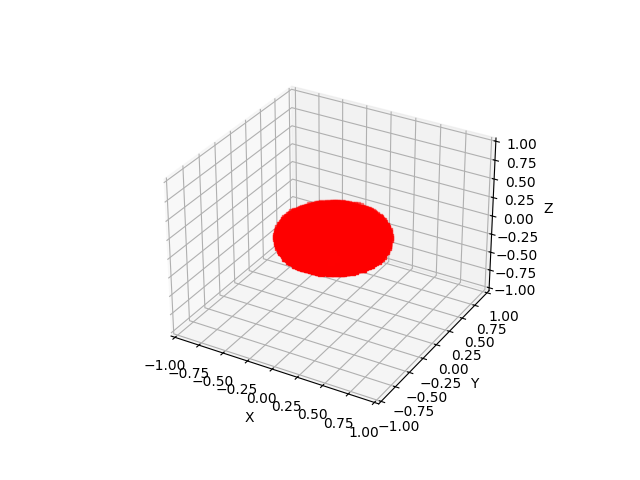

In [52]:
# Get the indices where is_fixed is equal to 1
indices = np.argwhere(is_fixed == 1)

# Plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_set[indices[:, 0]], y_set[indices[:, 1]], z_set[indices[:, 2]], c='r', marker=',')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

plt.show()

## Solving the Discretized Laplace Equation
Now that we have set the problem geometry, we proceed to numreically solve for the Laplace equation $\nabla^2U=0$ using Jacobi method. 

In [55]:
def iterate(U_old):
    U_new = np.zeros([L, M, N])

    for i in range(1, L-1):
        for j in range(1, M-1):
            for k in range(1, N-1):
                if is_fixed[i][j][k] == 1:
                    continue
            
                U_new = 1/6*(U_old[i-1][j][k] + U_old[i+1][j][k] + 
                            U_old[i][j-1][k] + U_old[i][j+1][k] +
                            U_old[i][j][k-1] + U_old[i][j][k+1])
    
    return U_new

0.0